# Results Analysis

The purpose of this notebook is to analyze the results from the RNN training experiments.

Unless otherwise stated, we will refer to the trained RNN as "the RNN". All validation numbers are RMSE.

## Environment Setup

In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from data_funcs import from_json

C:\Users\jhirs\anaconda3\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [3]:
results = from_json("../outputs/output_FMR.json")

reading  ../outputs/output_FMR.json
Hash:  29921943744713725


## Control Case

Case 11 with param set 0 was the reproducibility case.

In [4]:
pd.DataFrame(results['0']['cases']['case11'])

,RNN initial,RNN trained
all,1.498349,0.757118
predict,1.583437,0.732981
train,1.326955,0.799778


The RNN outperforms the KF in this case. Note the prediction RMSE is lower than the training RMSE for the RNN, indicating there are not signs of overfitting. The KF, by contrast, has very low training error but a prediction error over 3x larger.

## Summarise Results

### Param Set Descriptions

In [5]:
for i in range(1, len(results)):
    print('~'*50)
    print(f"Param Set {i}")
    print(f"Activation: {results[str(i)]['params']['activation']}")
    print(f"FM Increase: {results[str(i)]['params']['fm_raise_vs_rain']}")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Param Set 1
Activation: ['linear', 'linear']
FM Increase: 2.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Param Set 2
Activation: ['linear', 'linear']
FM Increase: 0.1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Param Set 3
Activation: ['tanh', 'tanh']
FM Increase: 2.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Param Set 4
Activation: ['tanh', 'tanh']
FM Increase: 0.1


### Extract Results

Excluding param set 0, as that was only run on case 11.

We summarise the RMSE for the param sets:

In [6]:
pd.DataFrame(results[str(1)]['cases']['WLCC2_202305010000'])

,RNN initial,RNN trained
all,164.028464,6.151124
predict,144.227007,6.754375
train,181.731380,5.479902


We next build a long-format dataframe with all of the results from the results dictionary. For each param set and model there are 3 time periods.

In [7]:
df = pd.DataFrame(columns=['Period', 'Case', 'RMSE', 'Model'])
for i in range(1, len(results)):
    for case in results[str(i)]['cases']:
        df_temp = pd.DataFrame(results[str(i)]['cases'][case])
        df_temp=df_temp.rename_axis("Period").reset_index()
        df_temp['Case']=np.repeat(case, 3)
        df_temp['param_set']=np.repeat(int(i), 3)
        df_temp=pd.melt(df_temp, id_vars=['Period', 'Case', 'param_set'], value_vars=['RNN initial', 'RNN trained'],
                     var_name='Model', value_name='RMSE')
        df = pd.concat((df, df_temp))

df

,Period,Case,RMSE,Model,param_set
0,all,AENC2_202305010000,183.857051,RNN initial,1.0
1,predict,AENC2_202305010000,54.947229,RNN initial,1.0
2,train,AENC2_202305010000,254.310090,RNN initial,1.0
3,all,AENC2_202305010000,5.972946,RNN trained,1.0
4,predict,AENC2_202305010000,6.439739,RNN trained,1.0
...,...,...,...,...,...
1,predict,WLCC2_202305010000,6.884011,RNN initial,4.0
2,train,WLCC2_202305010000,4.951584,RNN initial,4.0
3,all,WLCC2_202305010000,2.856659,RNN trained,4.0
4,predict,WLCC2_202305010000,3.311661,RNN trained,4.0


### Results by Param Set

Excluding RNN initial.

Text(0.5, 1.0, 'Results by Param Set')

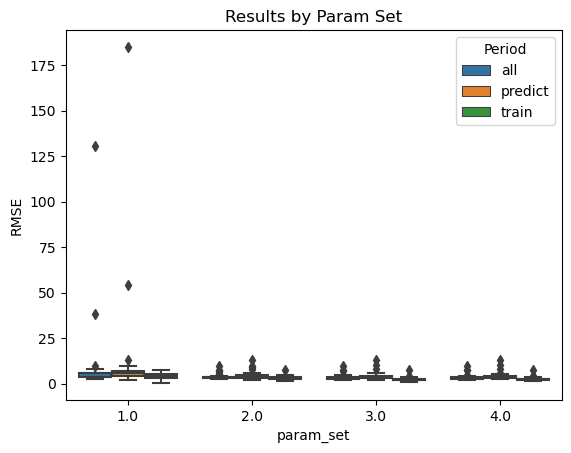

In [8]:
df2 = df[df.Model != 'RNN initial']
sns.boxplot(
    x=df2['param_set'],
    y=df2['RMSE'],
    hue=df2['Period']
).set_title('Results by Param Set')

Text(0.5, 1.0, 'Results by Param Set')

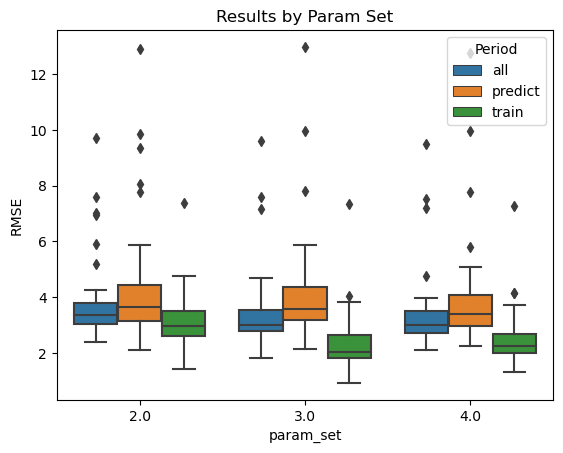

In [9]:
df2 = df[(df.Model != 'RNN initial')&(df.param_set != 1)]
sns.boxplot(
    x=df2['param_set'],
    y=df2['RMSE'],
    hue=df2['Period']
).set_title('Results by Param Set')

Print the group means for trained RNNs.

In [10]:
df2 = df[df.Model != 'RNN initial']
# Group by 'param_set' and 'Period' and calculate the mean of 'RMSE'
grouped_df = df2.groupby(['param_set', 'Period'])['RMSE'].mean().reset_index()

# Reshape the DataFrame using pivot_table
pivot_df = grouped_df.pivot_table(index='param_set', columns='Period', values='RMSE').reset_index()

# Optional: Rename columns if needed
pivot_df.columns.name = None  # Remove the 'Period' name from the columns
pivot_df.columns = ['param_set'] + [f'RMSE_{period}' for period in pivot_df.columns[1:]]
pivot_df

,param_set,RMSE_all,RMSE_predict,RMSE_train
0,1.0,8.924777,11.109045,4.256886
1,2.0,3.845006,4.288826,3.138931
2,3.0,3.383975,4.116094,2.322702
3,4.0,3.359611,3.944977,2.516139
